In [ ]:
!pip install torch_geometric
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import networkx as nx
import torch
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


In [ ]:
# Step 1: Data Loading and Preprocessing
def load_data(json_file: str) -> list:
    with open(json_file, 'r') as f:
        data = json.load(f)
    playlists = data['playlists']
    return playlists

playlists = load_data('/content/drive/MyDrive/slice 1-10 filtered_data.json')

Epoch 10, Training Loss: 0.5232, Validation Loss: 0.5372
Epoch 20, Training Loss: 0.4833, Validation Loss: 0.5150
Epoch 30, Training Loss: 0.4524, Validation Loss: 0.5088
Epoch 40, Training Loss: 0.4306, Validation Loss: 0.5403
Epoch 50, Training Loss: 0.4187, Validation Loss: 0.5730
Epoch 60, Training Loss: 0.4115, Validation Loss: 0.5845
Epoch 70, Training Loss: 0.4051, Validation Loss: 0.5976
Epoch 80, Training Loss: 0.4004, Validation Loss: 0.6034
Epoch 90, Training Loss: 0.3956, Validation Loss: 0.6054
Epoch 100, Training Loss: 0.4035, Validation Loss: 0.6352
Epoch 110, Training Loss: 0.3925, Validation Loss: 0.6066
Epoch 120, Training Loss: 0.3855, Validation Loss: 0.6189
Epoch 130, Training Loss: 0.3815, Validation Loss: 0.6274
Epoch 140, Training Loss: 0.3777, Validation Loss: 0.6395
Epoch 150, Training Loss: 0.3757, Validation Loss: 0.6579
Epoch 160, Training Loss: 0.3755, Validation Loss: 0.6426
Epoch 170, Training Loss: 0.3701, Validation Loss: 0.6535
Epoch 180, Training Los

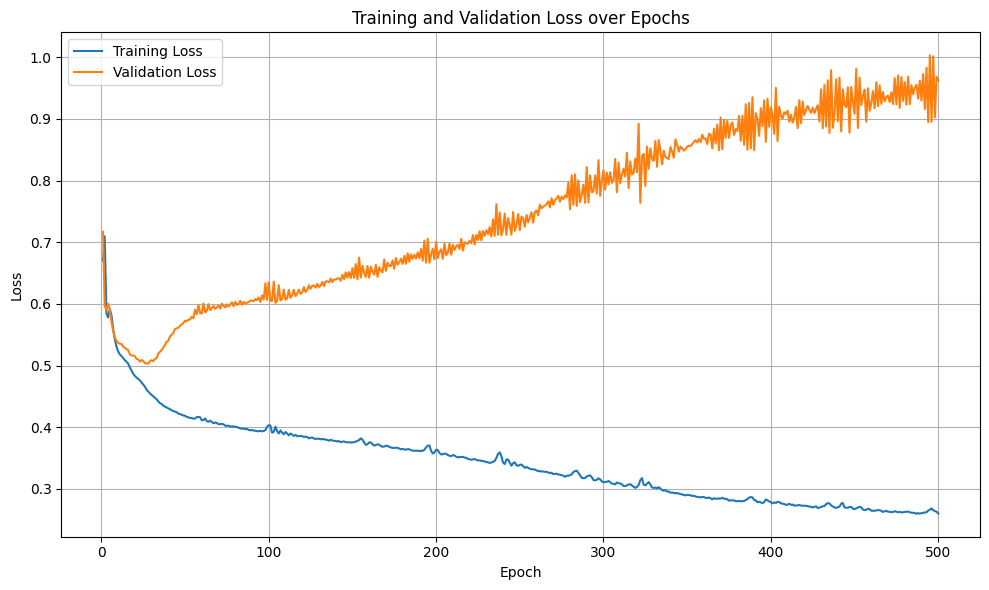

In [ ]:

# Build dictionaries for playlists and tracks
playlist_nodes = {}
track_nodes = {}
edges = []

# New: Dictionary to store track_id to "artist_name - track_name" mapping
track_id_to_display_name = {}

for playlist in playlists:
    pid = playlist['pid']
    playlist_nodes[pid] = {'type': 'playlist', 'tracks': []}
    for track in playlist['tracks']:
        tid = track['id']
        playlist_nodes[pid]['tracks'].append(tid)
        if tid not in track_nodes:
            # Use track attributes as features
            track_nodes[tid] = {
                'type': 'track',
                'x': [
                    track['danceability'],
                    track['key'],
                    track['mode'],
                    track['speechiness'],
                    track['acousticness'],
                    track['instrumentalness'],
                    track['liveness'],
                    track['tempo'],
                    track['duration_ms'],
                    track['time_signature']
                ]
            }
            # Store the combined artist_name and track_name
            artist = track.get('artist_name', "Unknown Artist")
            track_name = track.get('track_name', "Unknown Track")
            track_id_to_display_name[tid] = f"{artist} - {track_name}"
        edges.append((pid, tid))

# Normalize track features
track_features = np.array([track_nodes[tid]['x'] for tid in track_nodes])
scaler = StandardScaler()
track_features = scaler.fit_transform(track_features)
for i, tid in enumerate(track_nodes):
    # Convert the NumPy array to a list to prevent type mismatch
    track_nodes[tid]['x'] = track_features[i].tolist()

# Aggregate track features for playlists
for pid in playlist_nodes:
    track_ids = playlist_nodes[pid]['tracks']
    track_features_list = [track_nodes[tid]['x'] for tid in track_ids if tid in track_nodes]

    if track_features_list:
        try:
            # Convert list of lists to a 2D NumPy array
            track_features_array = np.vstack(track_features_list)
            # Compute the mean across tracks
            playlist_feature = np.mean(track_features_array, axis=0).tolist()  # Ensure it's a list
        except ValueError as ve:
            print(f"ValueError for playlist {pid}: {ve}")
            # Handle cases where stacking fails due to inconsistent shapes
            playlist_feature = [0.0] * track_features.shape[1]
    else:
        # If no tracks, assign a zero vector
        playlist_feature = [0.0] * track_features.shape[1]

    # Assign the computed feature to the playlist as a list
    playlist_nodes[pid]['x'] = playlist_feature

# Step 2: Graph Construction
B = nx.Graph()
# Add playlist nodes
for pid in playlist_nodes:
    B.add_node(pid, bipartite=0, x=torch.tensor(playlist_nodes[pid]['x'], dtype=torch.float), type='playlist')
# Add track nodes
for tid in track_nodes:
    B.add_node(tid, bipartite=1, x=torch.tensor(track_nodes[tid]['x'], dtype=torch.float), type='track')
# Add edges
B.add_edges_from(edges)

# Step 3: Prepare Data for PyG
# Store mappings between original IDs and node indices
original_id_to_node_index = {}
node_index_to_original_id = {}

# Relabel nodes to have consecutive integers and store mappings
mapping = {}
for i, node in enumerate(B.nodes()):
    mapping[node] = i
    original_id_to_node_index[node] = i
    node_index_to_original_id[i] = node

B = nx.relabel_nodes(B, mapping)

# Extract node features and types
x = []
node_types = []
for node in B.nodes(data=True):
    x.append(node[1]['x'])
    node_types.append(node[1]['type'])
x = torch.stack(x)

# Get edge indices
edge_index = torch.tensor(list(B.edges()), dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index)

# Identify playlist and track node indices
playlist_node_indices = [i for i, ntype in enumerate(node_types) if ntype == 'playlist']
track_node_indices = [i for i, ntype in enumerate(node_types) if ntype == 'track']

# Split edges into training, validation, and test sets with 80:10:10 ratio
edges_list = edge_index.t().tolist()

# First split: train (80%) and temp (20%)
edges_train, edges_temp = train_test_split(edges_list, test_size=0.2, random_state=42)

# Second split: validation (50% of temp -> 10% overall) and test (50% of temp -> 10% overall)
edges_val, edges_test = train_test_split(edges_temp, test_size=0.5, random_state=42)

# Convert lists back to tensors
edge_index_train = torch.tensor(edges_train, dtype=torch.long).t().contiguous()
edge_index_val = torch.tensor(edges_val, dtype=torch.long).t().contiguous()
edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()

# Create Data objects for train, validation, and test
data_train = Data(x=x, edge_index=edge_index_train)
data_val = Data(x=x, edge_index=edge_index_val)
data_test = Data(x=x, edge_index=edge_index_test)

# Step 4: Define the GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def encode(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Ensure edge_label_index is a tensor
        if not isinstance(edge_label_index, torch.Tensor):
            edge_label_index = torch.tensor(edge_label_index, dtype=torch.long).to(z.device)
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=1)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)

# Use device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=x.size(1), hidden_channels=160).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Step 5: Train the Model
# Function for negative sampling
def negative_sampling_bipartite(edge_index: torch.Tensor, playlist_node_indices: list, track_node_indices: list,
                                num_neg_samples: int, avoid_edges: torch.Tensor = None) -> torch.Tensor:
    import random
    import torch

    if avoid_edges is None:
        avoid_edges = set()
    else:
        avoid_edges = set(map(tuple, avoid_edges.t().tolist()))

    pos_edge_set = set(map(tuple, edge_index.t().tolist()))
    avoid_edge_set = pos_edge_set.union(avoid_edges)
    neg_edges = []
    while len(neg_edges) < num_neg_samples:
        pid = random.choice(playlist_node_indices)
        tid = random.choice(track_node_indices)
        if (pid, tid) not in avoid_edge_set:
            neg_edges.append([pid, tid])
            avoid_edge_set.add((pid, tid))
    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t().contiguous()
    return neg_edge_index

def train_step():
    model.train()
    optimizer.zero_grad()
    pos_edge_index = data_train.edge_index
    neg_edge_index = negative_sampling_bipartite(
        edge_index=pos_edge_index,
        playlist_node_indices=playlist_node_indices,
        track_node_indices=track_node_indices,
        num_neg_samples=pos_edge_index.size(1)
    )
    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ]).to(torch.float).to(device)
    out = model(data_train.x.to(device), data_train.edge_index.to(device), edge_label_index.to(device))
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        pos_edge_index = data_val.edge_index
        neg_edge_index = negative_sampling_bipartite(
            edge_index=pos_edge_index,
            playlist_node_indices=playlist_node_indices,
            track_node_indices=track_node_indices,
            num_neg_samples=pos_edge_index.size(1),
            avoid_edges=pos_edge_index
        )
        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_label = torch.cat([
            torch.ones(pos_edge_index.size(1)),
            torch.zeros(neg_edge_index.size(1))
        ]).to(torch.float).to(device)
        out = model(data_train.x.to(device), data_train.edge_index.to(device), edge_label_index.to(device))
        val_loss = criterion(out, edge_label).item()
    return val_loss

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop without callback and with training time measurement
start_time = time.time()  # Start timer

for epoch in range(1, 501):
    train_loss = train_step()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

end_time = time.time()  # End timer
training_time = end_time - start_time  # Total training time in seconds

# Step 6: Evaluation
def test():
    model.eval()
    with torch.no_grad():
        pos_edge_index = data_test.edge_index
        avoid_edges = torch.cat([data_train.edge_index, pos_edge_index], dim=1)
        neg_edge_index = negative_sampling_bipartite(
            edge_index=data_train.edge_index,
            playlist_node_indices=playlist_node_indices,
            track_node_indices=track_node_indices,
            num_neg_samples=pos_edge_index.size(1),
            avoid_edges=avoid_edges
        )
        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_label = torch.cat([
            torch.ones(pos_edge_index.size(1)),
            torch.zeros(neg_edge_index.size(1))
        ]).to(torch.float)

        # Move tensors to the device
        edge_label_index = edge_label_index.to(device)
        edge_label = edge_label.to(device)

        # Get raw output (logits)
        out = model(data_train.x.to(device), data_train.edge_index.to(device), edge_label_index)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(out).cpu().numpy()
        labels = edge_label.cpu().numpy()

        # Compute ROC AUC
        auc = roc_auc_score(labels, probs)

        # Binarize predictions with a threshold of 0.5
        preds = (probs >= 0.5).astype(int)

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(labels, preds)
        recall = recall_score(labels, preds)
        f1 = f1_score(labels, preds)

        print(f'AUC: {auc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')

        # Print Training Time
        print(f'Training Time: {training_time:.2f} seconds')

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 501), train_losses, label='Training Loss')
    plt.plot(range(1, 501), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

test()

# Step 7: Recommendation Function
def recommend_tracks(model: torch.nn.Module, playlist_id, N: int = 10) -> list:
    model.eval()
    with torch.no_grad():
        # Get the node index of the playlist
        if playlist_id not in original_id_to_node_index:
            print(f"Playlist ID {playlist_id} not found in the graph.")
            return []
        playlist_node_idx = original_id_to_node_index[playlist_id]

        # Get the set of tracks already in the playlist
        existing_tracks = set(playlist_nodes[playlist_id]['tracks'])

        # Get the node indices of existing tracks
        existing_track_indices = set(original_id_to_node_index[tid] for tid in existing_tracks)

        # Candidate track node indices (tracks not already in the playlist)
        candidate_track_indices = [idx for idx in track_node_indices if idx not in existing_track_indices]

        # If no candidates are available
        if not candidate_track_indices:
            print("No candidate tracks available for recommendation.")
            return []

        # Create edge index between the playlist node and candidate track nodes
        playlist_idx_tensor = torch.tensor([playlist_node_idx] * len(candidate_track_indices), dtype=torch.long)
        candidate_track_idx_tensor = torch.tensor(candidate_track_indices, dtype=torch.long)
        edge_label_index = torch.stack([playlist_idx_tensor, candidate_track_idx_tensor], dim=0)

        # Move data to the device
        edge_label_index = edge_label_index.to(device)
        x = data_train.x.to(device)
        edge_index = data_train.edge_index.to(device)

        # Get prediction scores
        scores = model(x, edge_index, edge_label_index)
        scores = torch.sigmoid(scores).cpu().numpy()

        # Get top-N tracks
        top_N_indices = np.argsort(-scores)[:N]
        recommended_track_indices = candidate_track_idx_tensor[top_N_indices].cpu().numpy()
        recommended_track_ids = [node_index_to_original_id[idx] for idx in recommended_track_indices]

        # Convert track IDs to "artist_name - track_name"
        recommended_track_names = [track_id_to_display_name.get(tid, tid) for tid in recommended_track_ids]

        return recommended_track_names



In [ ]:
# Step 8: User Interaction Loop
stop_words = ['stop', 'exit', 'quit']
print("\n--- Welcome to the Playlist Recommendation System ---")
print("You can enter a playlist ID and the number of recommendations you want.")
print("For example: '1000 10' to get top 10 recommendations for playlist ID 1000.")
print("Type 'stop', 'exit', or 'quit' to exit the recommendation loop.\n")

while True:
    user_input = input("Enter playlist ID and N (e.g., '1000 10'), or 'stop' to exit: ")
    if user_input.lower() in stop_words:
        print("Exiting recommendation loop.")
        break
    try:
        parts = user_input.strip().split()
        if len(parts) != 2:
            print("Please enter two values: playlist ID and N.\n")
            continue
        pid_input = parts[0]
        N_input = int(parts[1])
        # Handle numeric and string playlist IDs
        if pid_input.isdigit():
            pid = int(pid_input)
        else:
            pid = pid_input
        recommended_tracks = recommend_tracks(model, pid, N_input)
        if recommended_tracks:
            print(f"\nTop {N_input} recommended tracks for playlist {pid}:")
            for tid in recommended_tracks:
                print(tid)
            print()
        else:
            print("No recommendations found.\n")
    except ValueError:
        print("Invalid input. Please enter a valid playlist ID and N.\n")



--- Welcome to the Playlist Recommendation System ---
You can enter a playlist ID and the number of recommendations you want.
For example: '1000 10' to get top 10 recommendations for playlist ID 1000.
Type 'stop', 'exit', or 'quit' to exit the recommendation loop.


Top 10 recommended tracks for playlist 0:
Soulja Boy - Kiss Me Thru The Phone
The Black Eyed Peas - I Gotta Feeling
Taio Cruz - Dynamite
R. Kelly - Ignition - Remix
Fifth Harmony - Work from Home
Bruno Mars - That's What I Like
Kesha - TiK ToK
Gwen Stefani - Hollaback Girl
Fetty Wap - Trap Queen
Soulja Boy - Crank That (Soulja Boy)

Enter playlist ID and N (e.g., '1000 10'), or 'stop' to exit: exit
Exiting recommendation loop.
